In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader

In [2]:
data = pd.read_csv('../../ala2_.csv')

In [3]:
data

,time,phi,psi,theta,d1,d2,d3,d4,d5,d6,...,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21
0,0.0,1.158887,-0.062493,-0.277660,-2.025618,0.516963,1.492472,-0.950306,-0.774688,-2.048843,...,-0.963034,-0.890409,-0.893454,-0.832867,1.610624,-1.126497,-0.945604,-0.080917,0.514520,0.760415
1,1.0,1.111219,-0.603696,-0.070774,-0.512036,-0.285359,1.203746,-1.029504,-0.872391,-0.965547,...,-0.751681,0.006084,-0.994078,-0.958668,1.422885,-0.889166,-0.587028,0.328934,-0.156932,-0.063246
2,2.0,0.728072,-1.035362,0.393789,0.087397,-0.529289,0.746910,-0.824329,-0.874417,-0.644842,...,-1.252801,-0.922105,-1.203875,-1.245052,1.238570,-0.421943,-0.276024,1.256286,-1.323613,-1.144008
3,3.0,1.012503,-1.157839,0.017878,-1.245599,-0.811618,0.394611,-0.743993,-0.498255,-1.718372,...,-1.189851,-1.139319,-1.085646,-0.989156,0.596685,-0.313342,0.002932,1.350617,-1.397139,-1.732999
4,4.0,1.159205,-0.683593,0.131954,-0.113797,-0.196827,1.104845,-1.016574,-1.015251,-1.168208,...,-0.780271,-0.084586,-0.947399,-0.861555,1.179396,-0.897836,-0.940490,0.575624,-0.588955,-0.392952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,99996.0,-1.505169,1.366675,0.151529,-0.008643,-0.710419,0.425387,-0.732011,-0.687370,0.187693,...,-1.228254,-1.057929,-1.054951,-1.017247,0.247329,-0.908846,-1.000938,0.345989,1.113496,1.024112
99997,99997.0,-1.337126,1.426750,0.041038,0.960395,-0.924083,0.076492,-0.643308,-0.790167,0.630465,...,-1.041010,-0.997951,-0.900151,-0.988213,0.076130,-0.365033,-0.432474,-0.603332,0.989041,1.164272
99998,99998.0,-1.221497,1.162527,-0.217557,1.120643,-1.206279,0.536156,-1.067988,-1.138776,0.721807,...,-0.893825,-0.147857,-0.978662,-0.994951,0.949354,-0.664224,-0.735144,-1.072185,0.655099,0.339179
99999,99999.0,-1.327862,1.156643,-0.144797,1.290958,-0.955083,0.598453,-1.083222,-1.255012,0.781393,...,-0.916594,-0.134641,-1.044842,-1.027422,0.674525,-1.018527,-1.174485,-1.384781,0.708827,0.675896


In [4]:
data = data.drop(columns='time')

In [5]:
len(data)

100001

In [6]:
for col in data:
    print('Name: {},\tmax = {:.2f}\tmin = {:.2f}'.format(col, data[col].max(), data[col].min()))

Name: phi,	max = 3.14	min = -3.13
Name: psi,	max = 3.14	min = -3.14
Name: theta,	max = 0.93	min = -0.79
Name: d1,	max = 2.99	min = -5.13
Name: d2,	max = 3.18	min = -4.86
Name: d3,	max = 2.08	min = -3.99
Name: d4,	max = 1.79	min = -1.99
Name: d5,	max = 1.90	min = -2.33
Name: d6,	max = 1.99	min = -3.18
Name: d7,	max = 2.45	min = -2.86
Name: d8,	max = 2.75	min = -4.72
Name: d9,	max = 1.73	min = -1.52
Name: d10,	max = 1.82	min = -2.27
Name: d11,	max = 1.79	min = -3.21
Name: d12,	max = 2.21	min = -2.32
Name: d13,	max = 3.30	min = -6.06
Name: d14,	max = 1.89	min = -1.43
Name: d15,	max = 1.85	min = -1.75
Name: d16,	max = 2.01	min = -1.92
Name: d17,	max = 1.83	min = -2.16
Name: d18,	max = 2.20	min = -4.34
Name: d19,	max = 2.99	min = -2.21
Name: d20,	max = 1.84	min = -2.72
Name: d21,	max = 2.08	min = -6.01


In [7]:
data.head()

,phi,psi,theta,d1,d2,d3,d4,d5,d6,d7,...,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21
0,1.158887,-0.062493,-0.277660,-2.025618,0.516963,1.492472,-0.950306,-0.774688,-2.048843,-0.442294,...,-0.963034,-0.890409,-0.893454,-0.832867,1.610624,-1.126497,-0.945604,-0.080917,0.514520,0.760415
1,1.111219,-0.603696,-0.070774,-0.512036,-0.285359,1.203746,-1.029504,-0.872391,-0.965547,-0.370308,...,-0.751681,0.006084,-0.994078,-0.958668,1.422885,-0.889166,-0.587028,0.328934,-0.156932,-0.063246
2,0.728072,-1.035362,0.393789,0.087397,-0.529289,0.746910,-0.824329,-0.874417,-0.644842,-1.029328,...,-1.252801,-0.922105,-1.203875,-1.245052,1.238570,-0.421943,-0.276024,1.256286,-1.323613,-1.144008
3,1.012503,-1.157839,0.017878,-1.245599,-0.811618,0.394611,-0.743993,-0.498255,-1.718372,-1.183151,...,-1.189851,-1.139319,-1.085646,-0.989156,0.596685,-0.313342,0.002932,1.350617,-1.397139,-1.732999
4,1.159205,-0.683593,0.131954,-0.113797,-0.196827,1.104845,-1.016574,-1.015251,-1.168208,-0.671562,...,-0.780271,-0.084586,-0.947399,-0.861555,1.179396,-0.897836,-0.940490,0.575624,-0.588955,-0.392952


In [8]:
data_np = data.values

In [9]:
data_np.shape

(100001, 24)

In [10]:
data_np.max(), data_np.min()

(3.2956220000000003, -6.0561300000000005)

In [ ]:
norm = np.linalg.norm(data_np)
norm

In [ ]:
norm_arr = data_np/norm

In [ ]:
norm_arr.max(), norm_arr.min()

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(data_np)
data_np = sc.transform(data_np)

In [12]:
data_np.max(), data_np.min()

(6.170563387459025, -6.056129998944085)

# IDX -> input; IDX + LAG -> target

In [13]:
x = data_np[:-1, :]

In [14]:
y = data_np[1:, :]

In [15]:
tensor_data = TensorDataset(torch.from_numpy(np.float32(x)), torch.from_numpy(np.float32(y)))

In [16]:
tensor_data[:,:]

(tensor([[ 3.6518, -1.4151, -1.6173,  ..., -0.0809,  0.5145,  0.7604],
         [ 3.5913, -1.8809, -0.4423,  ...,  0.3289, -0.1569, -0.0632],
         [ 3.1045, -2.2525,  2.1959,  ...,  1.2563, -1.3236, -1.1440],
         ...,
         [ 0.4809, -0.1333,  0.1926,  ..., -0.6033,  0.9890,  1.1643],
         [ 0.6278, -0.3607, -1.2759,  ..., -1.0722,  0.6551,  0.3392],
         [ 0.4926, -0.3657, -0.8627,  ..., -1.3848,  0.7088,  0.6759]]),
 tensor([[ 3.5913, -1.8809, -0.4423,  ...,  0.3289, -0.1569, -0.0632],
         [ 3.1045, -2.2525,  2.1959,  ...,  1.2563, -1.3236, -1.1440],
         [ 3.4658, -2.3579,  0.0611,  ...,  1.3506, -1.3971, -1.7330],
         ...,
         [ 0.6278, -0.3607, -1.2759,  ..., -1.0722,  0.6551,  0.3392],
         [ 0.4926, -0.3657, -0.8627,  ..., -1.3848,  0.7088,  0.6759],
         [ 0.3906,  0.2431,  0.6792,  ..., -0.6379,  0.4360,  0.5153]]))

In [74]:
class AE(torch.nn.Module):
    def __init__(self, input_shape):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(input_shape, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)
        self.fc4 = nn.Linear(3, 8)
        self.fc5 = nn.Linear(8, 16)
        self.fc6 = nn.Linear(16, input_shape)
        
    def encoder(self, x):
        h1 = F.leaky_relu(self.fc1(x))
        h1 = F.leaky_relu(self.fc2(h1))
        return self.fc3(h1)
    
    def decoder(self, z):
        h2 = F.leaky_relu(self.fc4(z))
        h2 = F.leaky_relu(self.fc5(h2))
        return F.leaky_relu(self.fc6(h2))
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [95]:
ae = AE(input_shape=24)

In [96]:
ae

AE(
  (fc1): Linear(in_features=24, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=24, bias=True)
)

In [97]:
train_size = int(0.8 * len(tensor_data))
val_size = len(tensor_data) - train_size

train_d, val_d = random_split(tensor_data, (train_size, val_size))

train_data_loader = DataLoader(train_d, batch_size = 128, shuffle=True)
val_data_loader = DataLoader(val_d, batch_size = 128)

In [98]:
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss(size_average=False)

/Users/test/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [99]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs):
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        loss = 0.0
        valid_loss = 0.0
        for inputs, targets in train_loader:
            #reser gradients
            optimizer.zero_grad()
            #compute reconstructions
            outputs = model(inputs)
            #compute a training reconstruction loss
            train_loss = loss_fn(outputs, targets)
            #compute accumulated gradients
            train_loss.backward()
            #update parameters based on current gradients
            optimizer.step()
            #add the batch training loss to epoch loss
            loss += train_loss.item()
        #compute the epoch training loss
        loss = loss/len(train_loader.dataset)
        loss_list.append(loss)
        
        model.eval()
        for inputs, targets in val_loader:
            #compute reconstruction
            outputs = model(inputs)
            #compute validation loss
            valid_loss += loss_fn(outputs, targets)
        valid_loss /= len(val_loader.dataset)
        
        acc_list.append(valid_loss)
        #print info
        print('Epoch {} of {}, training loss = {:.3f}, validation loss = {:.3f}'.format(epoch+1, epochs, loss, valid_loss))
    return loss_list, acc_list

In [100]:
training_loss, val_loss = train(ae, train_data_loader, val_data_loader, optimizer, loss_fn, 100)

Epoch 1 of 100, training loss = 19.714, validation loss = 18.086
Epoch 2 of 100, training loss = 15.971, validation loss = 14.472
Epoch 3 of 100, training loss = 14.643, validation loss = 14.139
Epoch 4 of 100, training loss = 14.430, validation loss = 13.987
Epoch 5 of 100, training loss = 14.287, validation loss = 13.871
Epoch 6 of 100, training loss = 14.112, validation loss = 13.659
Epoch 7 of 100, training loss = 13.898, validation loss = 13.479
Epoch 8 of 100, training loss = 13.786, validation loss = 13.415
Epoch 9 of 100, training loss = 13.713, validation loss = 13.361
Epoch 10 of 100, training loss = 13.671, validation loss = 13.373
Epoch 11 of 100, training loss = 13.634, validation loss = 13.279
Epoch 12 of 100, training loss = 13.610, validation loss = 13.238
Epoch 13 of 100, training loss = 13.573, validation loss = 13.224
Epoch 14 of 100, training loss = 13.562, validation loss = 13.215
Epoch 15 of 100, training loss = 13.545, validation loss = 13.227
Epoch 16 of 100, tr

In [ ]:
for inp, tar in train_data_loader:
    err = 0.0
    for i in range(len(inp)):
        #print(inp[i])
        out = ae(inp[i].unsqueeze(0))
        #print(out)
        l = loss_fn(out.flatten(), inp[i])
        err += l
        break
    break

In [ ]:
err

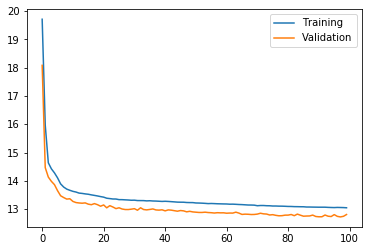

In [101]:
plt.plot(range(len(training_loss)), training_loss, label = 'Training')
plt.plot(range(len(val_loss)), val_loss, label = 'Validation')
plt.legend()
plt.show()

In [104]:
out = ae.encoder(tensor_data[:,:][0])
out = out.detach().numpy()

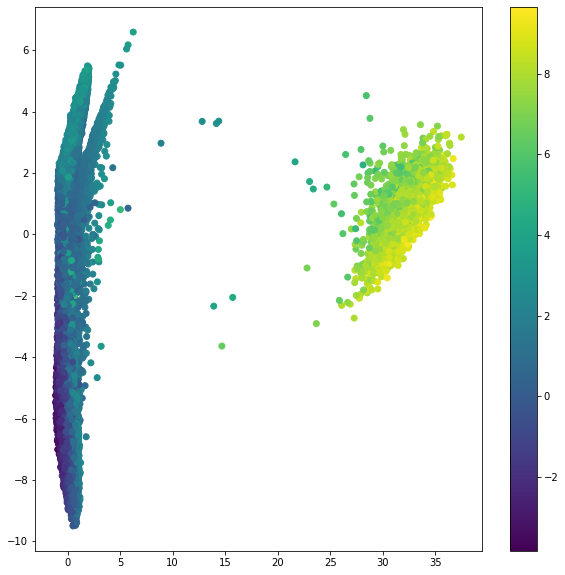

In [112]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(out[:,2], out[:,1], c=out[:,0])
plt.colorbar()
fig.savefig('reduced.png', dpi=200)